In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error, mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv(
    'C:/_Projects/home-energy-ai/data/raw/synthetic_power.csv',
    parse_dates=['last_changed']
)

df = df.set_index('last_changed')

df_resampled = df.resample("1h").mean(numeric_only=True)

df_resampled["state"] = df_resampled["state"].ffill().bfill()

df = df_resampled

print(df.head())



                           state
last_changed                    
2024-01-01 00:00:00  1438.793631
2024-01-01 01:00:00  1557.760188
2024-01-01 02:00:00  1605.485826
2024-01-01 03:00:00  1614.451601
2024-01-01 04:00:00  1692.457982


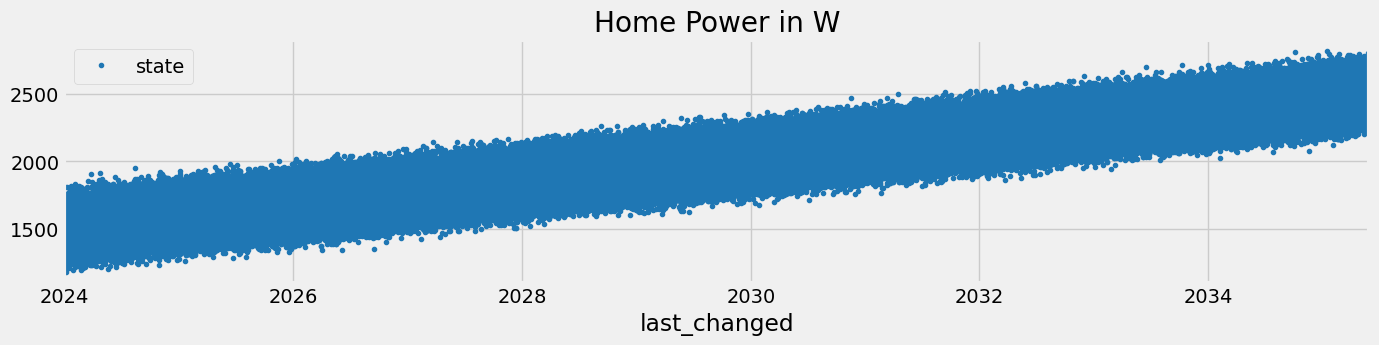

In [4]:

df.plot(style='.',
        figsize=(15, 3),
        color=color_pal[0],
        title='Home Power in W')
plt.show()



                           state
last_changed                    
2024-01-01 00:00:00  1438.793631
2024-01-01 01:00:00  1557.760188
2024-01-01 02:00:00  1605.485826
2024-01-01 03:00:00  1614.451601
2024-01-01 04:00:00  1692.457982
...                          ...
2032-12-31 19:00:00  2147.506016
2032-12-31 20:00:00  2008.015272
2032-12-31 21:00:00  2107.845915
2032-12-31 22:00:00  2145.363148
2032-12-31 23:00:00  2250.919325

[78912 rows x 1 columns]
                           state
last_changed                    
2033-01-01 00:00:00  2307.003009
2033-01-01 01:00:00  2312.676832
2033-01-01 02:00:00  2331.606086
2033-01-01 03:00:00  2501.349908
2033-01-01 04:00:00  2356.872066
...                          ...
2035-05-29 11:00:00  2562.817416
2035-05-29 12:00:00  2532.646155
2035-05-29 13:00:00  2474.595437
2035-05-29 14:00:00  2467.101965
2035-05-29 15:00:00  2322.001499

[21088 rows x 1 columns]


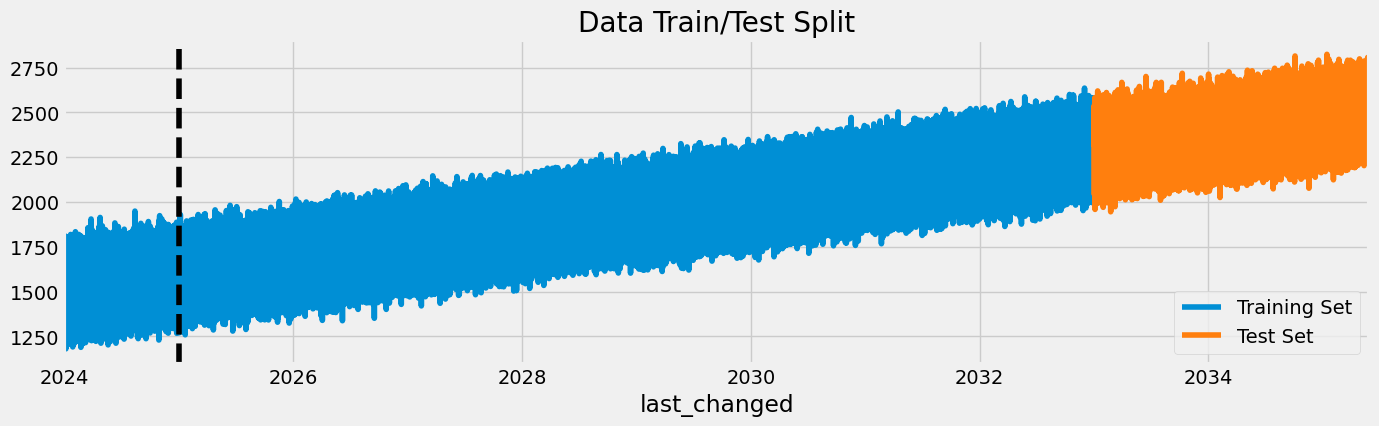

In [5]:
train = df.loc[df.index < '01-01-2033']
print(train)
test = df.loc[df.index >= '01-01-2033']
print(test)
fig, ax = plt.subplots(figsize=(15, 4))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set', color=color_pal[1])
ax.axvline('01-01-2025', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Visualize Week usage

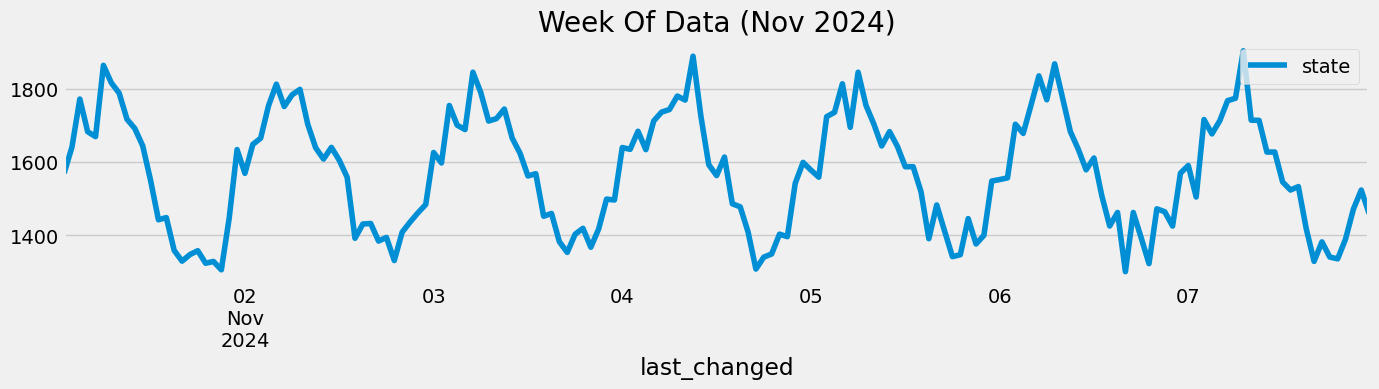

In [6]:
df.loc[(df.index > '11-01-2024') & (df.index < '11-08-2024')] \
    .plot(figsize=(15, 3), title='Week Of Data (Nov 2024)')
plt.show()

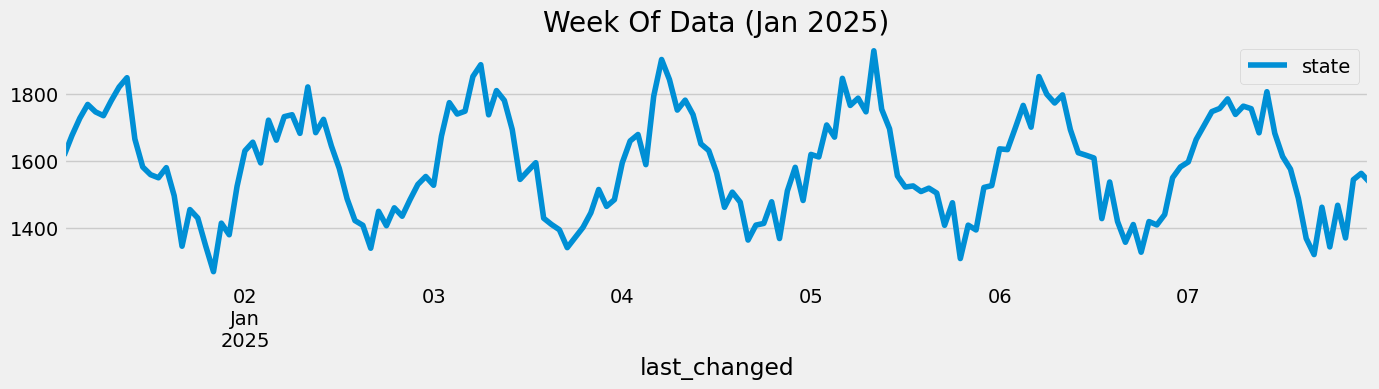

In [7]:
df.loc[(df.index > '1-01-2025') & (df.index < '1-08-2025')] \
    .plot(figsize=(15, 3), title='Week Of Data (Jan 2025)')
plt.show()

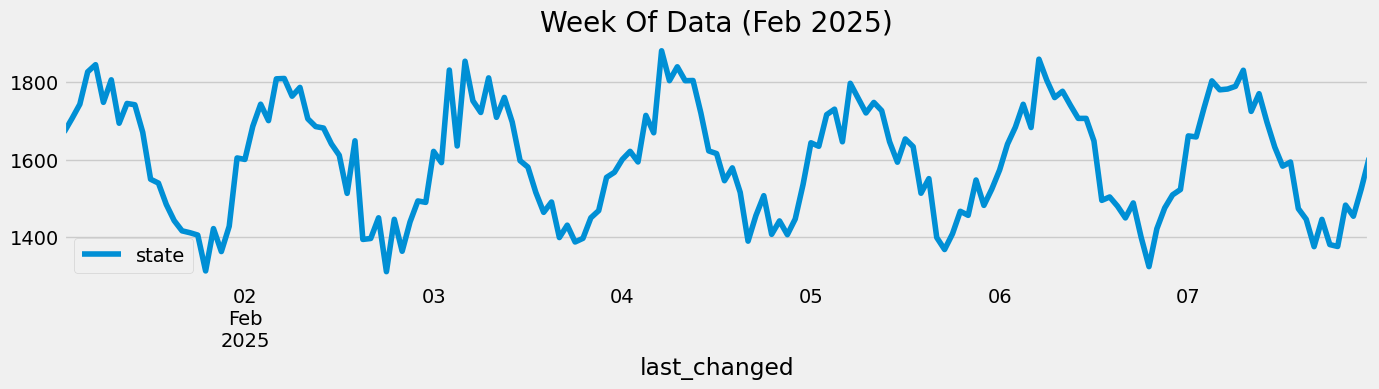

In [8]:
df.loc[(df.index > '2-01-2025') & (df.index < '2-08-2025')] \
    .plot(figsize=(15, 3), title='Week Of Data (Feb 2025)')
plt.show()

# Visualize Day Usage

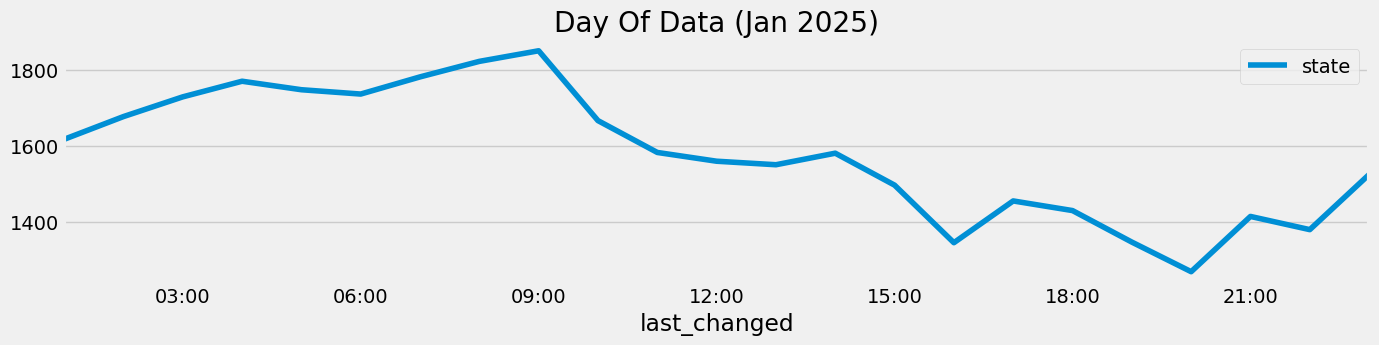

In [9]:
df.loc[(df.index > '1-01-2025') & (df.index < '1-02-2025')] \
    .plot(figsize=(15, 3), title='Day Of Data (Jan 2025)')
plt.show()

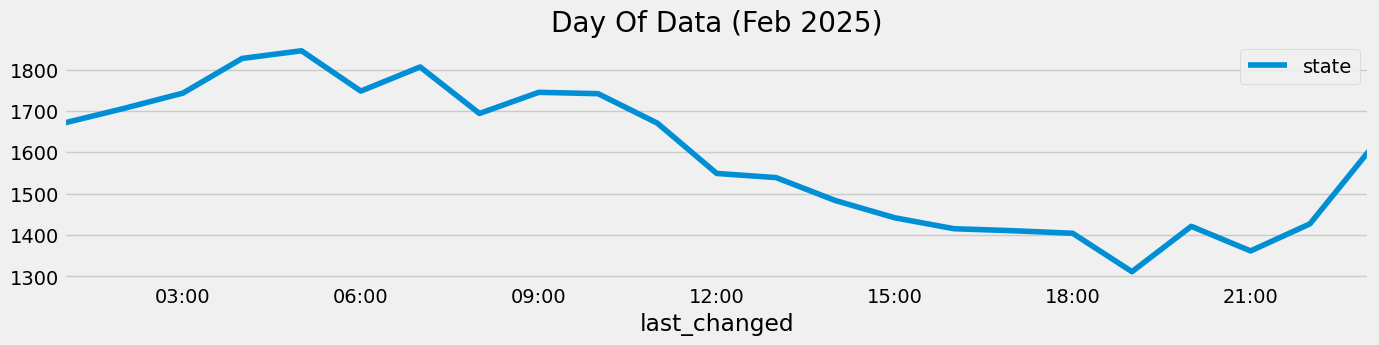

In [10]:
df.loc[(df.index > '2-01-2025') & (df.index < '2-02-2025')] \
    .plot(figsize=(15, 3), title='Day Of Data (Feb 2025)')
plt.show()

# Feature Creation

In [11]:
### Feature Creation
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['prev_hour'] = df['state'].shift(1)  # Lagged consumption
    df['prev_day'] = df['state'].shift(24)  # Consumption same time yesterday
    df['rolling_mean_6h'] = df['state'].rolling(6).mean()
    df['rolling_std_6h'] = df['state'].rolling(6).std()
    df['rolling_max_6h'] = df['state'].rolling(6).max()

    return df

df = create_features(df)

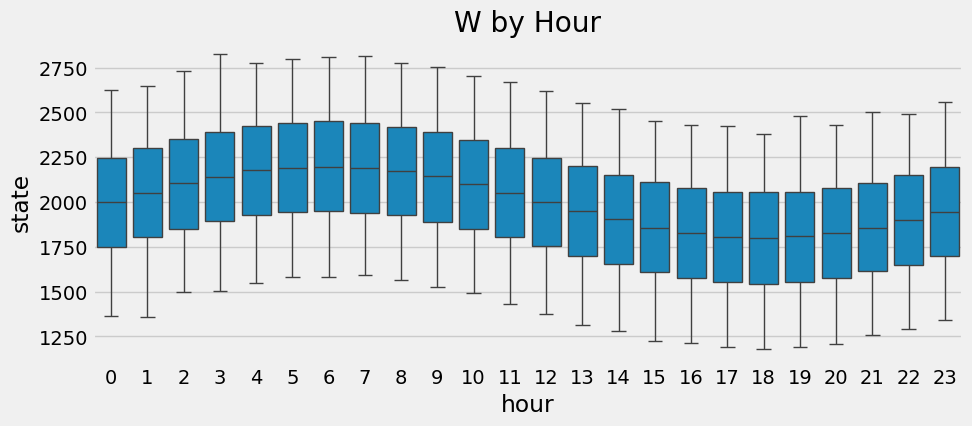

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x='hour', y='state')
ax.set_title('W by Hour')
plt.show()

C:\Users\adamm\AppData\Local\Temp\ipykernel_31388\2960673189.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='state', palette='Blues')


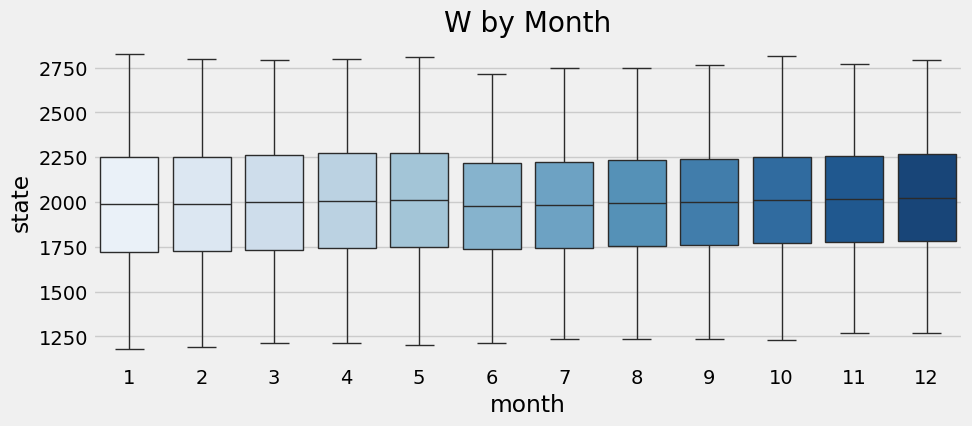

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df, x='month', y='state', palette='Blues')
ax.set_title('W by Month')
plt.show()

----
# Creating Model

In [14]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'state'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [15]:
# XGBoost model with hyperparameter tuning
params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [16]:
reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

cv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(reg, params, cv=cv, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train, y_train)

[0]	validation_0-rmse:196.76122	validation_1-rmse:415.17583
[99]	validation_0-rmse:48.10080	validation_1-rmse:174.57987
Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 9], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='neg_mean_absolute_error', verbose=1)

MAPE: 0.0641
MSLE: 0.0056
Peak Error: 244.8305


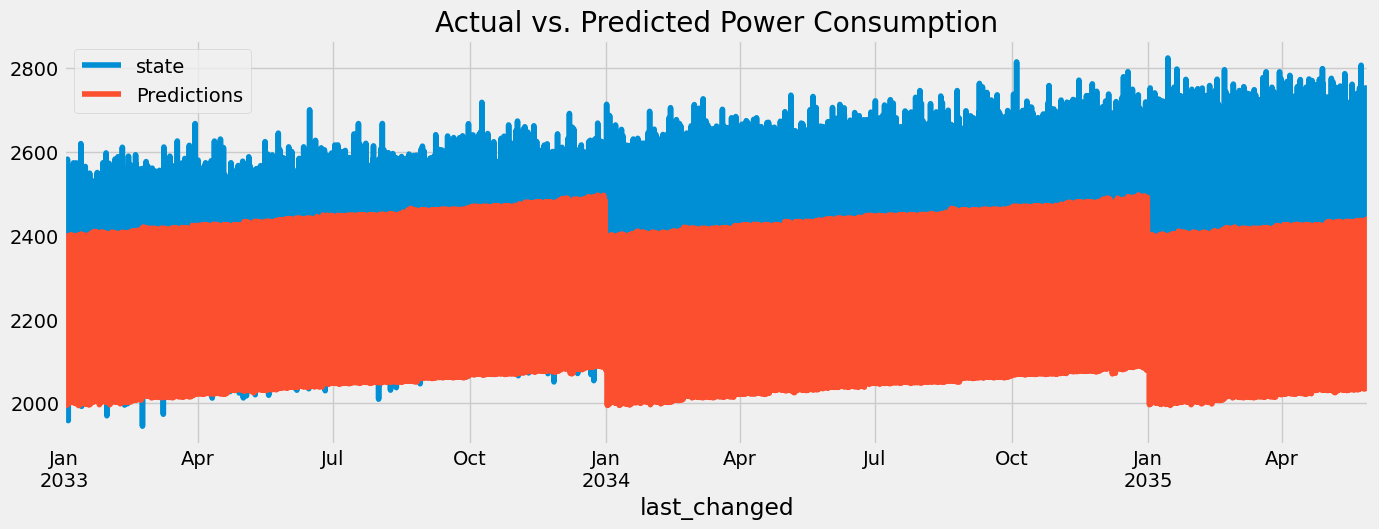

In [17]:
# Best model
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

# Evaluation Metrics
mape = mean_absolute_percentage_error(y_test, y_pred)
msle = mean_squared_log_error(y_test, y_pred)

def peak_error(y_true, y_pred):
    peak_indices = np.where(y_true > np.percentile(y_true, 90))[0]
    return np.mean(np.abs(y_true.iloc[peak_indices] - y_pred[peak_indices]))

peak_err = peak_error(y_test, y_pred)

print(f"MAPE: {mape:.4f}")
print(f"MSLE: {msle:.4f}")
print(f"Peak Error: {peak_err:.4f}")

# Plot predictions vs actual
test['Predictions'] = y_pred
test[['state', 'Predictions']].plot(figsize=(15, 5), title='Actual vs. Predicted Power Consumption')
plt.show()


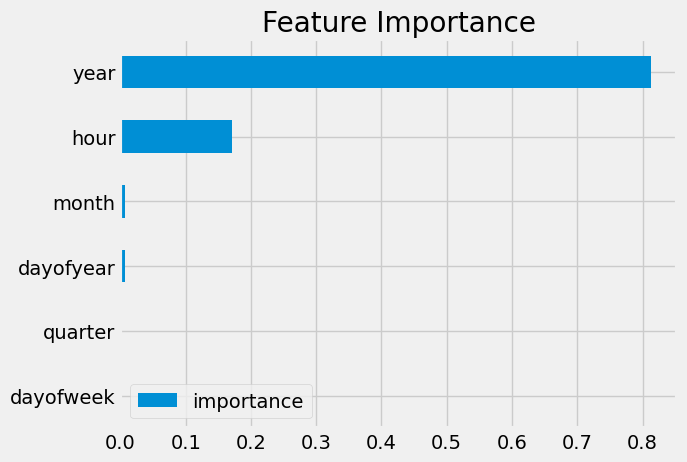

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index=reg.feature_names_in_,
                columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

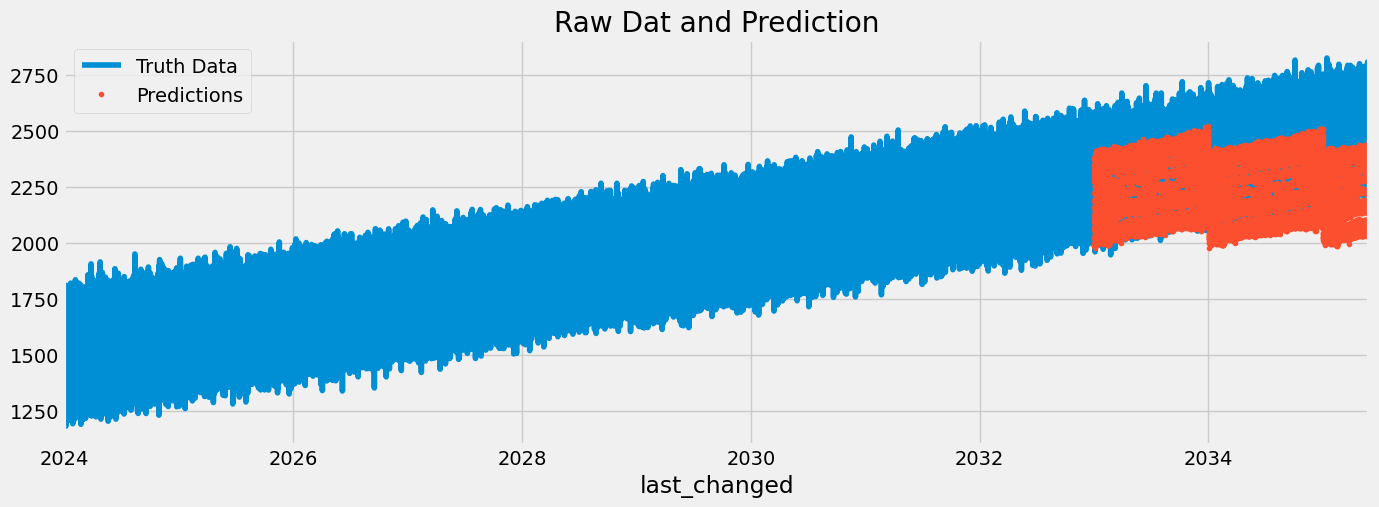

In [19]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['state']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

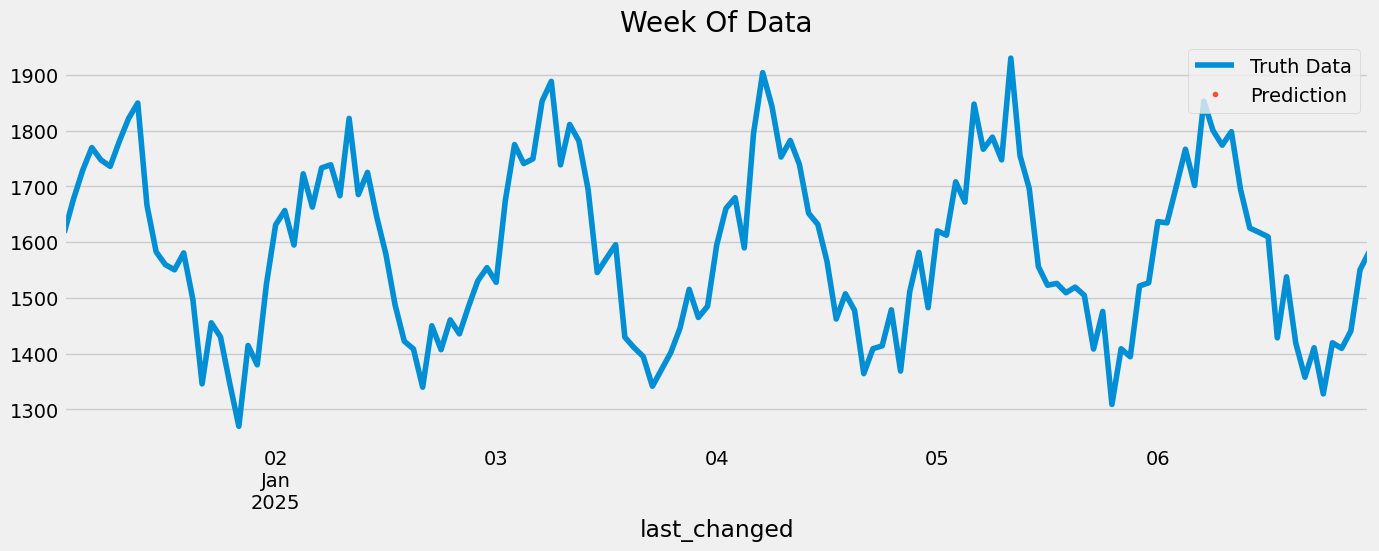

In [20]:
ax = df.loc[(df.index > '1-01-2025') & (df.index < '1-07-2025')]['state'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '1-01-2025') & (df.index < '1-07-2025')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [21]:
score = np.sqrt(mean_squared_error(test['state'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 174.58


# Calculate Error (worst and best days)

In [22]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2035-04-28    294.913897
2035-04-21    294.333906
2035-03-13    294.224539
2035-03-25    289.153096
2035-02-06    288.136637
2035-05-22    286.250343
2035-02-20    285.153484
2035-01-05    282.656684
2035-01-27    281.465700
2035-03-22    281.238227
Name: error, dtype: float64

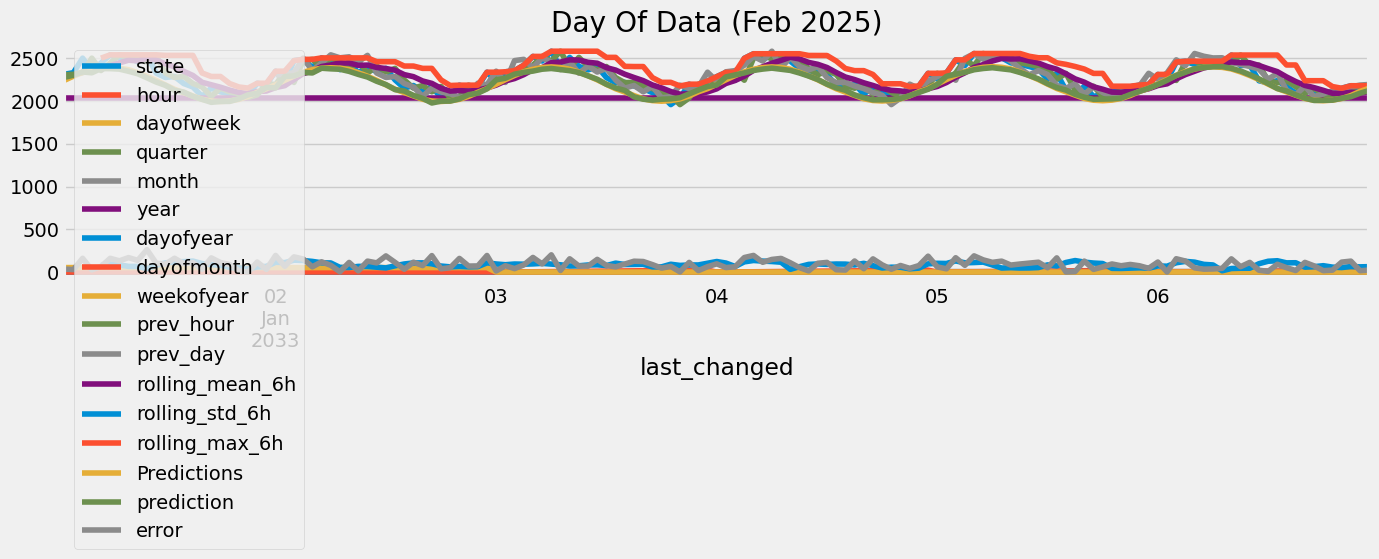

In [23]:
# Function to plot predictions vs actual over a date range
def plot_predictions(start_date, end_date):
    test.loc[(test.index > start_date) & (test.index < end_date)] \
        .plot(figsize=(15, 3), title='Day Of Data (Feb 2025)')
    plt.show()


# print(test.head())
# Plot predictions vs actual
plot_predictions('1-01-2033', '1-07-2033')


# df.loc[(df.index > '2-01-2025') & (df.index < '2-02-2025')] \
#     .plot(figsize=(15, 3), title='Day Of Data (Feb 2025)')
# plt.show()
